In [2]:
import tensorflow as tf
from tensorflow import keras
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import time

2023-08-19 23:15:17.644228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-19 23:15:17.840526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-19 23:15:17.841788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-19 23:15:18.725077: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
mnist =tf.keras.datasets.mnist
(train_images,_), (_,_) = mnist.load_data()
train_images=train_images.reshape(train_images.shape[0],28, 28, 1).astype('float32')

In [37]:
train_images=(train_images-127.5)/127.5
BUFFER_SIZE=60000
BATCH_SIZE=256
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## GENERADOR DE RUIDO

In [38]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (Dense, 
                                    Reshape, 
                                    Conv2DTranspose, 
                                    BatchNormalization,
                                    LeakyReLU)

def make_generator_model():
    model = Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))

    model.add(Reshape((7,7,256)))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, (5,5), strides=(2, 2), padding='same', activation='tanh'))

    return model


generator = make_generator_model()
generator.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1254400   
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 14, 14, 128)       819328    
 Transpose)                                                      
                                                                 
 batch_normalization_14 (Ba  (None, 14, 14, 128)       512       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_10 (Conv2  (None, 14, 14, 64)       

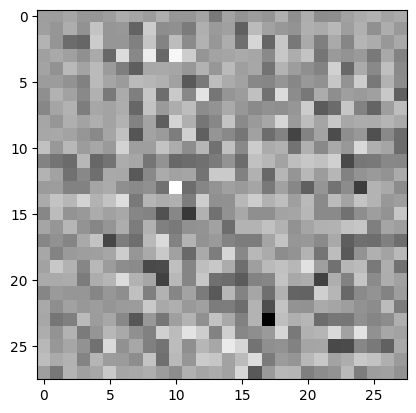

In [39]:
noise_dim= 100
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [40]:
from tensorflow.keras.layers import Conv2D, Flatten 
def make_discriminator_model():
    model=Sequential()
    model.add(Conv2D(32, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU(alpha=0.01))

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))


    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator= make_discriminator_model()
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 14, 14, 32)        832       
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 14, 14, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 64)          51264     
                                                                 
 batch_normalization_16 (Ba  (None, 7, 7, 64)          256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 7, 7, 64)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 128)         204928    
                                                     

In [41]:
from tensorflow.keras.losses import BinaryCrossentropy
cross_entropy= BinaryCrossentropy(from_logits=True)

In [42]:
from tensorflow import ones_like, zeros_like
def discriminator_loss(real_output, fake_output):
    real_loss= cross_entropy(ones_like(real_output), real_output)
    fake_loss= cross_entropy(zeros_like(fake_output), fake_output)
    total_loss= real_loss+fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(ones_like(fake_output), fake_output)

In [43]:
from tensorflow.keras.optimizers import Adam

generator_optimizer= Adam(1e-4)
discriminator_optimizer= Adam(1e-4)

## Custom trainging method

In [47]:
from tensorflow import function
from tensorflow.random import normal
@function
def train_step(images):
    noise = normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss=generator_loss(fake_output)
        disc_loss= discriminator_loss(generated_images, fake_output)
    
    generator_gradients= gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients=disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))


In [48]:
grid_size_x= 10
grid_size_y= 10
def generate_images(model, test_input):
    predictions=model(test_input, training=False)
    fig = plt.figure(figsize=(grid_size_x, grid_size_y))
    for i in range(predictions.shape[0]):
        plt.subplot(grid_size_x, grid_size_y, i+1)
        plt.imshow(predictions[i,:,:,0] * 127.5+127.5, cmap='gray')
        plt.axis='off'
    plt.show()

In [50]:
import time

grid_size_x= 10
grid_size_y= 10
seed = tf.random.normal([grid_size_x*grid_size_y , noise_dim])

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    generate_images(generator,seed)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_images(generator, seed)

In [51]:
train(train_dataset, 50)

KeyboardInterrupt: 